In [12]:
import numpy as np
import fixed_income_derivatives_E2025 as fid
import matplotlib.pyplot as plt
from scipy.optimize import minimize  # , Bounds, NonlinearConstraint
from scipy.special import ndtr

5Y swap before changes. S_5Y_swap: 4.688311500676128, R_5Y_swap: 0.025770000000081925
5Y swap after shift in all ZCB spot rates. S_5Y_swap: 4.686932677419535, R_5Y_swap: 0.025871348479965604, DV01: -0.04750135021736117
5Y swap after shift in only 5Y ZCB spot rate. S_5Y_swap: 4.6878720194492765, R_5Y_swap: 0.025866164455126087, DV01: -0.04508066580671118
5Y swap after shift in 5Y swap market rate. S_5Y_swap: 4.6878544923328604, R_5Y_swap: 0.025870000000093363, DV01: -0.046878544928690646


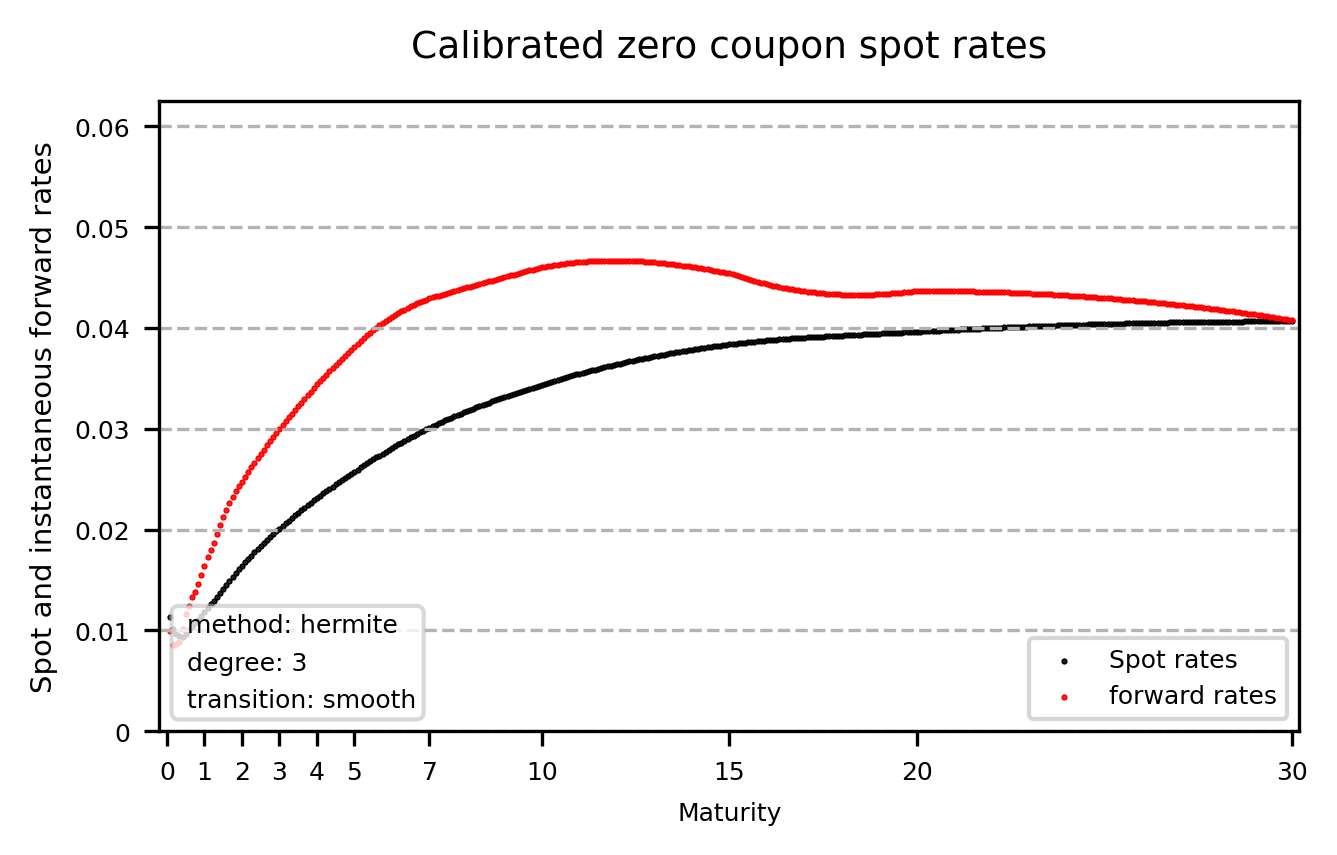

In [13]:

EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.00967}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.00980},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.01043},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.01130},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.01217},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.01317},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.01399},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.01478},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.01560},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.01637}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.01652, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.02019, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.02319, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.02577, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.02995, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.03395, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.03753, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.03873, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.03975, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

# interpolation_options = {"method":"linear","transition": "smoo"}
interpolation_options = {"method":"hermite","degree":3,"transition": "smooth"}
# interpolation_options = {"method":"nelson_siegel","transition": "smooth"}

# Problem 2a - Fitting a ZCB term structure to the market data.
mesh = 1/12
M = 360
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
T_inter = np.array([i*mesh for i in range(0,M+1)])
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter,T_fit,R_fit,interpolation_options = interpolation_options)

# 5Y interest rate swap before shift
T_5Y_swap_fixed_leg = np.array([i for i in range(0,6)])
p_5Y_swap_fixed_leg = np.array(fid.for_values_in_list_find_value_return_value(T_5Y_swap_fixed_leg,T_inter,p_inter))
S_5Y_swap = 0
for i in range(1,len(T_5Y_swap_fixed_leg)):
    S_5Y_swap += (T_5Y_swap_fixed_leg[i] - T_5Y_swap_fixed_leg[i-1])*p_5Y_swap_fixed_leg[i]
R_5Y_swap = (1-p_5Y_swap_fixed_leg[-1])/S_5Y_swap
print(f"5Y swap before changes. S_5Y_swap: {S_5Y_swap}, R_5Y_swap: {R_5Y_swap}")

# Shifting the entire spot rate zcb_curve
R_inter_zcb_shift = R_inter + np.array([0] + [0.0001 for i in range(1,len(R_inter))])
p_inter_zcb_shift = fid.zcb_prices_from_spot_rates(T_inter,R_inter_zcb_shift)
p_5Y_swap_fixed_leg_zcb_shift = np.array(fid.for_values_in_list_find_value_return_value(T_5Y_swap_fixed_leg,T_inter,p_inter_zcb_shift))
S_5Y_swap_zcb_shift = 0
for i in range(1,len(T_5Y_swap_fixed_leg)):
    S_5Y_swap_zcb_shift += (T_5Y_swap_fixed_leg[i] - T_5Y_swap_fixed_leg[i-1])*p_5Y_swap_fixed_leg_zcb_shift[i]
R_5Y_swap_zcb_shift = (1-p_5Y_swap_fixed_leg_zcb_shift[-1])/S_5Y_swap_zcb_shift
print(f"5Y swap after shift in all ZCB spot rates. S_5Y_swap: {S_5Y_swap_zcb_shift}, R_5Y_swap: {R_5Y_swap_zcb_shift}, DV01: {S_5Y_swap_zcb_shift*(R_5Y_swap-R_5Y_swap_zcb_shift)*100}")

# Shifting only the 5Y zcb rate
R_bump_5Y = np.zeros([len(R_inter)])
R_bump_5Y[60] = 0.0001
R_inter_5Y_shift = R_inter + R_bump_5Y
p_inter_5Y_shift = fid.zcb_prices_from_spot_rates(T_inter,R_inter_5Y_shift)
p_5Y_swap_fixed_leg_5Y_shift = np.array(fid.for_values_in_list_find_value_return_value(T_5Y_swap_fixed_leg,T_inter,p_inter_5Y_shift))
S_5Y_swap_5Y_shift = 0
for i in range(1,len(T_5Y_swap_fixed_leg)):
    S_5Y_swap_5Y_shift += (T_5Y_swap_fixed_leg[i] - T_5Y_swap_fixed_leg[i-1])*p_5Y_swap_fixed_leg_5Y_shift[i]
R_5Y_swap_5Y_shift = (1-p_5Y_swap_fixed_leg_5Y_shift[-1])/S_5Y_swap_5Y_shift
print(f"5Y swap after shift in only 5Y ZCB spot rate. S_5Y_swap: {S_5Y_swap_5Y_shift}, R_5Y_swap: {R_5Y_swap_5Y_shift}, DV01: {S_5Y_swap_5Y_shift*(R_5Y_swap-R_5Y_swap_5Y_shift)*100}")

# Shifting the 5Y swap market rate
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.00967}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.00980},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.01043},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.01130},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.01217},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.01317},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.01399},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.01478},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.01560},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.01637}]
swap_market_mr_shift = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.01652, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.02019, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.02319, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.02577 + 0.0001, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.02995, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.03395, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.03753, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.03873, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.03975, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data_mr_shift = EURIBOR_fixing + fra_market + swap_market_mr_shift

T_fit_mr_shift, R_fit_mr_shift = fid.zcb_curve_fit(data_mr_shift,interpolation_options = interpolation_options)
T_inter_mr_shift = np.array([i*mesh for i in range(0,M+1)])
p_inter_mr_shift, R_inter_mr_shift, f_inter_mr_shift, T_inter_mr_shift = fid.zcb_curve_interpolate(T_inter_mr_shift,T_fit_mr_shift,R_fit_mr_shift,interpolation_options = interpolation_options)

p_5Y_swap_fixed_leg_mr_shift = np.array(fid.for_values_in_list_find_value_return_value(T_5Y_swap_fixed_leg,T_inter_mr_shift,p_inter_mr_shift))
S_5Y_swap_mr_shift = 0
for i in range(1,len(T_5Y_swap_fixed_leg)):
    S_5Y_swap_mr_shift += (T_5Y_swap_fixed_leg[i] - T_5Y_swap_fixed_leg[i-1])*p_5Y_swap_fixed_leg_mr_shift[i]
R_5Y_swap_mr_shift = (1-p_5Y_swap_fixed_leg_mr_shift[-1])/S_5Y_swap_mr_shift
print(f"5Y swap after shift in 5Y swap market rate. S_5Y_swap: {S_5Y_swap_mr_shift}, R_5Y_swap: {R_5Y_swap_mr_shift}, DV01: {S_5Y_swap_mr_shift*(R_5Y_swap-R_5Y_swap_mr_shift)*100}")

fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
ax.set_ylabel(f"Spot and instantaneous forward rates",fontsize = 7)
plt.grid(axis = 'y', which='major', color = (0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[1:], R_inter[1:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter[1:], f_inter[1:], s = 1, color = 'red', marker = ".",label="forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
bbox = {"facecolor": (1,1,1,0.8),"edgecolor": (0.7,0.7,0.7,0.5),"boxstyle": "Round"}
if interpolation_options["method"] == "hermite":
    ax.text(0.32,0.0024,f" method: {interpolation_options['method']} \n degree: {interpolation_options['degree']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
else:
    ax.text(0.32,0.0024,f" method: {interpolation_options['method']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
# fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/plot_2a.pdf")
plt.show()



In [14]:

###############################################################################
######################## Vasicek_example.py ###################################
###############################################################################

r0, a, b, sigma = 0.02, 0.6, 0.03, 0.02
T_max, T_mesh = 10, 1/12

# ZCB prices, spot rates and instantaneous forward rates
T = np.array([i*T_mesh for i in range(0,int(T_max/T_mesh)+1)])
p = fid.zcb_price_vasicek(r0,a,b,sigma,T)
R = fid.spot_rate_vasicek(r0,a,b,sigma,T)
f = fid.forward_rate_vasicek(r0,a,b,sigma,T)

# Problem 2 - Fitting the Vasicek Model
def fit_vasicek_obj(param,R_star,T,scaling = 1):
    r0, a, b, sigma = param
    M = len(T)
    R_fit = fid.spot_rate_vasicek(r0,a,b,sigma,T)
    sse = 0
    for m in range(0,M):
        sse += scaling*(R_fit[m] - R_star[m])**2
    return sse

def fit_vasicek_sigma_fixed_obj(param,sigma,R_star,T,scaling = 1):
    r0, a, b = param
    M = len(T)
    R_fit = fid.spot_rate_vasicek(r0,a,b,sigma,T)
    sse = 0
    for m in range(0,M):
        sse += scaling*(R_fit[m] - R_star[m])**2
    return sse

param_0 = (0.03, 0.5, 0.04, 0.04)
# print(show_options(solver = "minimize", method = "nelder-mead"))
result = minimize(fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-8,'disp': True})
r0_hat, a_hat, b_hat, sigma_hat, fct_value = result.x[0], result.x[1], result.x[2], result.x[3], result.x
print(f"2b - r0_hat: {r0_hat}, a_hat: {a_hat}, b_hat: {b_hat}, sigma_hat: {sigma_hat}, opt: {result.x}, sse: {result.fun}")
result = minimize(fit_vasicek_sigma_fixed_obj,param_0[0:3],method = 'nelder-mead',args = (0.02,R,T),options={'xatol': 1e-8,'disp': True})
r0_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1], result.x[2], result.x
print(f"2c - r0_hat: {r0_hat}, a_hat: {a_hat}, b_hat: {b_hat}, sigma_hat: {sigma_hat}, opt: {result.x}, sse: {result.fun}")

# Problem 3 - Swap rates for swaps paying 6M Libor against an annual fixed rate
T_6m = np.array([i*0.5 for i in range(int(T_max/0.5)+1)])
p_6m = fid.zcb_price_vasicek(r0,a,b,sigma,T_6m)
f_6m = fid.forward_rates_from_zcb_prices(T_6m,p_6m,horizon = 1,method = "simple")
T_swap = np.array([i for i in range(0,T_max+1)])
R_swap = np.nan*np.ones([T_max+1])
for i in range(1,T_max+1):
    R_swap[i], S = fid.swap_rate_from_zcb_prices(0,0,T_swap[i],"annual",T,p,"semiannual",L = 0)

# Problem 4 - Caplet and cap prices
strike = 0.05
alpha = 0.5
M = int(T_max/alpha) + 1
T_caplet = np.array([i*alpha for i in range(0,M)])
p_caplet = fid.zcb_price_vasicek(r0,a,b,sigma,T_caplet)
price_caplet = np.zeros([len(T_caplet)])
for i in range(2,len(T_caplet)):
    price_caplet[i] = (1 + (T_caplet[i]-T_caplet[i-1])*strike)*fid.euro_option_price_vasicek(1/(1 + (T_caplet[i]-T_caplet[i-1])*strike),T_caplet[i-1],T_caplet[i],p_caplet[i-1],p_caplet[i],a,sigma,type_option = "put")
# price_caplet = fid.caplet_prices_vasicek(sigma,strike,a,T_caplet,p_caplet)
price_cap = sum(price_caplet[2:])
S_swap = fid.accrual_factor_from_zcb_prices(0,0,T_caplet[-1],"semiannual",T,p)
premium_cap = alpha*(price_cap/S_swap)
print(f"Caplet prices: {10000*price_caplet}")
print(f"price_cap: {10000*price_cap}, premium_cap: {10000*premium_cap}")
price_caplet_down = fid.caplet_prices_vasicek(sigma-0.001,strike,a,T_caplet,p_caplet)
price_cap_down = sum(price_caplet_down[2:])
premium_cap_down = alpha*(price_cap_down/S_swap)
print(f"price_cap_down: {10000*price_cap_down}, premium_cap_down: {10000*premium_cap_down}")
price_caplet_up = fid.caplet_prices_vasicek(sigma+0.001,strike,a,T_caplet,p_caplet)
price_cap_up = sum(price_caplet_up[2:])
premium_cap_up = alpha*(price_cap_up/S_swap)
print(f"price_cap_up: {10000*price_cap_up}, premium_cap_up: {10000*premium_cap_up}")

# Problem 5 - Simulation of the short rate in the Vasicak model
seed = np.random.seed(13)
M_simul, T_simul = 1000, 10
size_ci = 0.95
r_simul = fid.simul_vasicek(r0,a,b,sigma,M_simul,T_simul,method = "exact",seed = seed)
t_simul = np.array([i*(T_simul/M_simul) for i in range(0,M_simul+1)])
lb, ub = fid.ci_vasicek(r0,a,b,sigma,t_simul,size_ci)
mu_sd, sigma_sd = fid.mean_vasicek(r0,a,b,sigma,np.inf), fid.stdev_vasicek(r0,a,b,sigma,np.inf)
lb_sd = fid.ci_vasicek(r0,a,b,sigma,np.inf,size_ci,type_ci = "lower")[0]
ub_sd = fid.ci_vasicek(r0,a,b,sigma,np.inf,size_ci,type_ci = "upper")[1]

# Problem 6 - Computing the price of a 2Y8Y swaption using simulation
T_n, T_N = 2, 10
strike = 0.045
M_simul_swaption, N_simul, T_simul_swaption = 2000, 10000, T_n
chi, price_swaption_simul, price_swaption_plot = np.zeros([N_simul]), np.zeros([N_simul]), np.zeros([N_simul])
T_swaption = np.array([i*0.5 for i in range(0,17)])
T_jams = np.array([i for i in range(0,9)])
for i in range(0,N_simul):
    r_simul_swaption = fid.simul_vasicek(r0,a,b,sigma,M_simul_swaption,T_n,method = "exact",seed = None)
    p_swaption = fid.zcb_price_vasicek(r_simul_swaption[-1],a,b,sigma,T_swaption)
    R_swaption, S_swaption = fid.swap_rate_from_zcb_prices(0,0,T_N-T_n,"annual",T_swaption,p_swaption,float_freq = "semiannual")
    chi[i] = max(R_swaption - strike,0)*S_swaption
    chi_jams = fid.swaption_payoff_vasicek(r_simul_swaption[-1],strike,a,b,sigma,T_jams)
    r_star_jams = fid.r_star_jams_vasicek(strike,a,b,sigma,T_jams)
    # print(f"chi: {chi[i]}, chi_jams: {chi_jams}, r_2: {r_simul_swaption[-1]}, r_star_jams: {r_star_jams}, test: {fid.swaption_payoff_vasicek(r_star_jams,strike,a,b,sigma,T_jams)}")
    price_swaption_simul[i] = np.exp(-(T_simul_swaption/M_simul_swaption)*sum(r_simul_swaption[0:M_simul_swaption]))*chi[i]
    price_swaption_plot[i] = 10000*sum(price_swaption_simul[0:i+1])/(i+1)
print(f"Simulation: price_swaption: {price_swaption_plot[-1]}")

# Problem 7 - Computing the price of a 2Y8Y swaption using simulation
swaption_price_jams = fid.swaption_price_vasicek(T_n,T_N,strike,"annual",r0,a,b,sigma,type_swap = "payer")
print(f"swaption_price_jams: {10000*swaption_price_jams}")

# Fitting the term structure of ZCB spot rates.
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03723}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03938},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.04139},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.04329},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04507},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.04673},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.04830},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.04976},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.05114},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.05242}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.05089, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.05536, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.05786, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.05915, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.05985, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05922, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05776, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05678, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05579, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

# interpolation_options = {"method":"linear","transition": "smoo"}
interpolation_options = {"method":"hermite","degree":3,"transition": "smooth"}
# interpolation_options = {"method":"nelson_siegel","transition": "smooth"}

T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
T_inter = np.array([i*1/12 for i in range(0,361)])
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter,T_fit,R_fit,interpolation_options = interpolation_options)

# Fitting the Vasicek model to market data
param_0 = 0.03, 0.5, 0.04, 0.04
result = minimize(fid.fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")
r0_fit, a_fit, b_fit, sigma_fit = result.x
R_vas_fit = fid.spot_rate_vasicek(r0_fit, a_fit, b_fit, sigma_fit,T_inter)

# PLot of zcb prices, spot rates and forward rates in the Vasicek model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Spot- and forward rates in the Vasicek model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Maturity",fontsize = 7)
yticks1 = [0,0.2,0.4,0.6,0.8,1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"ZCB Prices",fontsize = 7)
p1 = ax.scatter(T, p, s = 2, color = 'black', marker = ".",label="ZCB prices")
ax2 = ax.twinx()
yticks2 = [0,0.01,0.02,0.03,0.04,0.05]
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2,fontsize = 6)
ax2.set_ylim([yticks2[0],yticks2[-1]+(yticks2[-1]-yticks2[0])*0.02])
ax2.set_ylabel(f"Spot and forward rates",fontsize = 7)
p2 = ax2.scatter(T, R, s = 2, color = 'red', marker = ".",label="Spot rate")
p3 = ax2.scatter(T, f, s = 2, color = 'blue', marker = ".",label="Instantaneous forward rate")
p4 = ax2.scatter(T_6m, f_6m, s = 2, color = 'orange', marker = ".",label="6M forward rate")
p5 = ax2.scatter(T_swap, R_swap, s = 2, color = 'green', marker = ".",label="Par swap rate")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 5)

# PLot of simulated short rates in the Vasicek model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated spot rates in the Vasicek model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul, r_simul, s = 1, color = 'black', marker = ".",label="Simulated short rate")
p2 = ax.scatter(t_simul, lb, s = 1, color = 'red', marker = ".",label=f"Lower {size_ci} CB")
p3 = ax.scatter(t_simul, ub, s = 1, color = 'red', marker = ".",label=f"Upper {size_ci} CB")
p4 = ax.scatter(t_simul, lb_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Lower {size_ci} CB Stat. dist.")
p5 = ax.scatter(t_simul, ub_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Upper {size_ci} CB Stat. dist.")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)

fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
ax.set_ylabel(f"Spot and instantaneous forward rates",fontsize = 7)
plt.grid(axis = 'y', which='major', color = (0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[1:], R_inter[1:], s = 1, color = 'blue', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter[1:], f_inter[1:], s = 1, color = 'red', marker = ".",label="forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
# fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
bbox = {"facecolor": (1,1,1,0.8),"edgecolor": (0.7,0.7,0.7,0.5),"boxstyle": "Round"}
if interpolation_options["method"] == "hermite":
    ax.text(0.32,0.0024,f" method: {interpolation_options['method']} \n degree: {interpolation_options['degree']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
else:
    ax.text(0.32,0.0024,f" method: {interpolation_options['method']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
# fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/plot_2a.pdf")
plt.show()



2b - r0_hat: 0.019999996496623, a_hat: 0.6000010510349127, b_hat: 0.030000017572083156, sigma_hat: 0.019999100892032926, opt: [0.02       0.60000105 0.03000002 0.0199991 ], sse: 2.2966415127172874e-16
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 135
         Function evaluations: 240
2c - r0_hat: 0.0199999999879167, a_hat: 0.5999999973531729, b_hat: 0.029999999877485993, sigma_hat: 0.019999100892032926, opt: [0.02 0.6  0.03], sse: 9.365764769639908e-20
Caplet prices: [ 0.          0.          0.82727383  4.92962125  9.78459279 14.003043
 17.28465884 19.6804256  21.33830596 22.41599481 23.05217838 23.35958339
 23.42612138 23.31867153 23.08729692 22.76905597 22.39115737 21.97345193
 21.53034602 21.07224436 20.60662489]
price_cap: 356.85064818963457, premium_cap: 21.986708297323425


/var/folders/ch/svk174ms2t7404n3sl5_kg380000gn/T/ipykernel_48204/335151456.py:35: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-8,'disp': True})


TypeError: euro_option_price_vasicek() got an unexpected keyword argument 'type'

In [ ]:

###############################################################################
######################## Vasicek_example.py ###################################
###############################################################################

r0, a, b, sigma = 0.02, 0.6, 0.03, 0.02
T_max, T_mesh = 10, 1/12

# ZCB prices, spot rates and instantaneous forward rates
T = np.array([i*T_mesh for i in range(0,int(T_max/T_mesh)+1)])
p = fid.zcb_price_vasicek(r0,a,b,sigma,T)
R = fid.spot_rate_vasicek(r0,a,b,sigma,T)
f = fid.forward_rate_vasicek(r0,a,b,sigma,T)

# Problem 2 - Fitting the Vasicek Model
def fit_vasicek_obj(param,R_star,T,scaling = 1):
    r0, a, b, sigma = param
    M = len(T)
    R_fit = fid.spot_rate_vasicek(r0,a,b,sigma,T)
    sse = 0
    for m in range(0,M):
        sse += scaling*(R_fit[m] - R_star[m])**2
    return sse

def fit_vasicek_sigma_fixed_obj(param,sigma,R_star,T,scaling = 1):
    r0, a, b = param
    M = len(T)
    R_fit = fid.spot_rate_vasicek(r0,a,b,sigma,T)
    sse = 0
    for m in range(0,M):
        sse += scaling*(R_fit[m] - R_star[m])**2
    return sse

param_0 = (0.03, 0.5, 0.04, 0.04)
# print(show_options(solver = "minimize", method = "nelder-mead"))
result = minimize(fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-8,'disp': True})
r0_hat, a_hat, b_hat, sigma_hat, fct_value = result.x[0], result.x[1], result.x[2], result.x[3], result.x
print(f"2b - r0_hat: {r0_hat}, a_hat: {a_hat}, b_hat: {b_hat}, sigma_hat: {sigma_hat}, opt: {result.x}, sse: {result.fun}")
result = minimize(fit_vasicek_sigma_fixed_obj,param_0[0:3],method = 'nelder-mead',args = (0.02,R,T),options={'xatol': 1e-8,'disp': True})
r0_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1], result.x[2], result.x
print(f"2c - r0_hat: {r0_hat}, a_hat: {a_hat}, b_hat: {b_hat}, sigma_hat: {sigma_hat}, opt: {result.x}, sse: {result.fun}")

# Problem 3 - Swap rates for swaps paying 6M Libor against an annual fixed rate
T_6m = np.array([i*0.5 for i in range(int(T_max/0.5)+1)])
p_6m = fid.zcb_price_vasicek(r0,a,b,sigma,T_6m)
f_6m = fid.forward_rates_from_zcb_prices(T_6m,p_6m,horizon = 1,method = "simple")
T_swap = np.array([i for i in range(0,T_max+1)])
R_swap = np.nan*np.ones([T_max+1])
for i in range(1,T_max+1):
    R_swap[i], S = fid.swap_rate_from_zcb_prices(0,0,T_swap[i],"annual",T,p,"semiannual",L = 0)

# Problem 4 - Caplet and cap prices
strike = 0.05
alpha = 0.5
M = int(T_max/alpha) + 1
T_caplet = np.array([i*alpha for i in range(0,M)])
p_caplet = fid.zcb_price_vasicek(r0,a,b,sigma,T_caplet)
price_caplet = np.zeros([len(T_caplet)])
for i in range(2,len(T_caplet)):
    price_caplet[i] = (1 + (T_caplet[i]-T_caplet[i-1])*strike)*fid.euro_option_price_vasicek(1/(1 + (T_caplet[i]-T_caplet[i-1])*strike),T_caplet[i-1],T_caplet[i],p_caplet[i-1],p_caplet[i],a,sigma,type_option = "put")
# price_caplet = fid.caplet_prices_vasicek(sigma,strike,a,T_caplet,p_caplet)
price_cap = sum(price_caplet[2:])
S_swap = fid.accrual_factor_from_zcb_prices(0,0,T_caplet[-1],"semiannual",T,p)
premium_cap = alpha*(price_cap/S_swap)
print(f"Caplet prices: {10000*price_caplet}")
print(f"price_cap: {10000*price_cap}, premium_cap: {10000*premium_cap}")
price_caplet_down = fid.caplet_prices_vasicek(sigma-0.001,strike,a,T_caplet,p_caplet)
price_cap_down = sum(price_caplet_down[2:])
premium_cap_down = alpha*(price_cap_down/S_swap)
print(f"price_cap_down: {10000*price_cap_down}, premium_cap_down: {10000*premium_cap_down}")
price_caplet_up = fid.caplet_prices_vasicek(sigma+0.001,strike,a,T_caplet,p_caplet)
price_cap_up = sum(price_caplet_up[2:])
premium_cap_up = alpha*(price_cap_up/S_swap)
print(f"price_cap_up: {10000*price_cap_up}, premium_cap_up: {10000*premium_cap_up}")

# Problem 5 - Simulation of the short rate in the Vasicak model
seed = np.random.seed(13)
M_simul, T_simul = 1000, 10
size_ci = 0.95
r_simul = fid.simul_vasicek(r0,a,b,sigma,M_simul,T_simul,method = "exact",seed = seed)
t_simul = np.array([i*(T_simul/M_simul) for i in range(0,M_simul+1)])
lb, ub = fid.ci_vasicek(r0,a,b,sigma,t_simul,size_ci)
mu_sd, sigma_sd = fid.mean_vasicek(r0,a,b,sigma,np.inf), fid.stdev_vasicek(r0,a,b,sigma,np.inf)
lb_sd = fid.ci_vasicek(r0,a,b,sigma,np.inf,size_ci,type_ci = "lower")[0]
ub_sd = fid.ci_vasicek(r0,a,b,sigma,np.inf,size_ci,type_ci = "upper")[1]

# Problem 6 - Computing the price of a 2Y8Y swaption using simulation
T_n, T_N = 2, 10
strike = 0.045
M_simul_swaption, N_simul, T_simul_swaption = 2000, 10000, T_n
chi, price_swaption_simul, price_swaption_plot = np.zeros([N_simul]), np.zeros([N_simul]), np.zeros([N_simul])
T_swaption = np.array([i*0.5 for i in range(0,17)])
T_jams = np.array([i for i in range(0,9)])
for i in range(0,N_simul):
    r_simul_swaption = fid.simul_vasicek(r0,a,b,sigma,M_simul_swaption,T_n,method = "exact",seed = None)
    p_swaption = fid.zcb_price_vasicek(r_simul_swaption[-1],a,b,sigma,T_swaption)
    R_swaption, S_swaption = fid.swap_rate_from_zcb_prices(0,0,T_N-T_n,"annual",T_swaption,p_swaption,float_freq = "semiannual")
    chi[i] = max(R_swaption - strike,0)*S_swaption
    chi_jams = fid.swaption_payoff_vasicek(r_simul_swaption[-1],strike,a,b,sigma,T_jams)
    r_star_jams = fid.r_star_jams_vasicek(strike,a,b,sigma,T_jams)
    # print(f"chi: {chi[i]}, chi_jams: {chi_jams}, r_2: {r_simul_swaption[-1]}, r_star_jams: {r_star_jams}, test: {fid.swaption_payoff_vasicek(r_star_jams,strike,a,b,sigma,T_jams)}")
    price_swaption_simul[i] = np.exp(-(T_simul_swaption/M_simul_swaption)*sum(r_simul_swaption[0:M_simul_swaption]))*chi[i]
    price_swaption_plot[i] = 10000*sum(price_swaption_simul[0:i+1])/(i+1)
print(f"Simulation: price_swaption: {price_swaption_plot[-1]}")

# Problem 7 - Computing the price of a 2Y8Y swaption using simulation
swaption_price_jams = fid.swaption_price_vasicek(T_n,T_N,strike,"annual",r0,a,b,sigma,type_swap = "payer")
print(f"swaption_price_jams: {10000*swaption_price_jams}")

# Fitting the term structure of ZCB spot rates.
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03723}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03938},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.04139},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.04329},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04507},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.04673},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.04830},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.04976},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.05114},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.05242}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.05089, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.05536, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.05786, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.05915, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.05985, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05922, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05776, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05678, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05579, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

# interpolation_options = {"method":"linear","transition": "smoo"}
interpolation_options = {"method":"hermite","degree":3,"transition": "smooth"}
# interpolation_options = {"method":"nelson_siegel","transition": "smooth"}

T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
T_inter = np.array([i*1/12 for i in range(0,361)])
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter,T_fit,R_fit,interpolation_options = interpolation_options)

# Fitting the CIR model to market data
param_0 = 0.03, 0.5, 0.04, 0.04
result = minimize(fid.fit_cir_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")
r0_fit, a_fit, b_fit, sigma_fit = result.x
R_vas_fit = fid.spot_rate_cir(r0_fit, a_fit, b_fit, sigma_fit,T_inter)

# PLot of zcb prices, spot rates and forward rates in the CIR model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Spot- and forward rates in the CIR model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Maturity",fontsize = 7)
yticks1 = [0,0.2,0.4,0.6,0.8,1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"ZCB Prices",fontsize = 7)
p1 = ax.scatter(T, p, s = 2, color = 'black', marker = ".",label="ZCB prices")
ax2 = ax.twinx()
yticks2 = [0,0.01,0.02,0.03,0.04,0.05]
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2,fontsize = 6)
ax2.set_ylim([yticks2[0],yticks2[-1]+(yticks2[-1]-yticks2[0])*0.02])
ax2.set_ylabel(f"Spot and forward rates",fontsize = 7)
p2 = ax2.scatter(T, R, s = 2, color = 'red', marker = ".",label="Spot rate")
p3 = ax2.scatter(T, f, s = 2, color = 'blue', marker = ".",label="Instantaneous forward rate")
p4 = ax2.scatter(T_6m, f_6m, s = 2, color = 'orange', marker = ".",label="6M forward rate")
p5 = ax2.scatter(T_swap, R_swap, s = 2, color = 'green', marker = ".",label="Par swap rate")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 5)

# PLot of simulated short rates in the CIR model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated spot rates in the CIR model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul, r_simul, s = 1, color = 'black', marker = ".",label="Simulated short rate")
p2 = ax.scatter(t_simul, lb, s = 1, color = 'red', marker = ".",label=f"Lower {size_ci} CB")
p3 = ax.scatter(t_simul, ub, s = 1, color = 'red', marker = ".",label=f"Upper {size_ci} CB")
p4 = ax.scatter(t_simul, lb_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Lower {size_ci} CB Stat. dist.")
p5 = ax.scatter(t_simul, ub_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Upper {size_ci} CB Stat. dist.")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)

# Plot of the swaption price as a function of N_simul
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Swaption price as a function of number of simulations",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,int((1/5)*N_simul),int((2/5)*N_simul),int((3/5)*N_simul),int((4/5)*N_simul),int(N_simul)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-2,xticks[-1]+2])
plt.xlabel(f"Number of simulations",fontsize = 7)
yticks1 = [0,50,100,150,200]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Swaption price",fontsize = 7)
p1 = ax.scatter([i for i in range(1,N_simul+1)], price_swaption_plot, s = 1, color = 'black', marker = ".",label=f"Swaption price in bps: {np.round(price_swaption_plot[-1],2)}")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
# plt.show()

# Plot of the digital option price as a function of N_simul
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Price of the digital option as a function of number of simulations",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,int((1/5)*N_simul_digital),int((2/5)*N_simul_digital),int((3/5)*N_simul_digital),int((4/5)*N_simul_digital),int(N_simul_digital)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-2,xticks[-1]+2])
plt.xlabel(f"Number of simulations",fontsize = 7)
yticks1 = [0,25,0.5,0.75,1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Swaption price",fontsize = 7)
p1 = ax.scatter([i for i in range(1,N_simul_digital+1)], price_digital_plot, s = 1, color = 'red', marker = ".",label=f"Digital option price: {np.round(price_digital_plot[-1],4)}")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()


2b - r0_hat: 0.019999996496623, a_hat: 0.6000010510349127, b_hat: 0.030000017572083156, sigma_hat: 0.019999100892032926, opt: [0.02       0.60000105 0.03000002 0.0199991 ], sse: 2.2966415127172874e-16
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 135
         Function evaluations: 240
2c - r0_hat: 0.0199999999879167, a_hat: 0.5999999973531729, b_hat: 0.029999999877485993, sigma_hat: 0.019999100892032926, opt: [0.02 0.6  0.03], sse: 9.365764769639908e-20


/var/folders/ch/svk174ms2t7404n3sl5_kg380000gn/T/ipykernel_45918/1873772915.py:35: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-8,'disp': True})


TypeError: forward_rates_from_zcb_prices() got an unexpected keyword argument 'type_option'

In [ ]:

#############################################################################
######################## CIR MODEL EXAMPLE ##################################
#############################################################################


r0, a, b, sigma = 0.032, 1.2, 0.048, 0.1
T_max, T_mesh = 10, 0.1

# Problem 2 - ZCB prices, spot rates and instantaneous forward rates.
T = np.array([i*T_mesh for i in range(0,int(T_max/T_mesh)+1)])
p = fid.zcb_price_cir(r0,a,b,sigma,T)
R = fid.spot_rate_cir(r0,a,b,sigma,T)
f = fid.forward_rate_cir(r0,a,b,sigma,T)

# Fitting the CIR model (To itself)
param_0 = 0.03, 0.5, 0.04, 0.04
result = minimize(fid.fit_cir_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-20,'disp': True})
print(f"Problem 2. Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")

sigma = 0.1
param_0 = 0.03, 0.5, 0.04
result = minimize(fid.fit_cir_no_sigma_obj,param_0,method = 'nelder-mead',args = (sigma,R,T),options={'xatol': 1e-20,'disp': True})
print(f"Problem 2. Parameters from the fit when sigma=0.1 is assumed: {result.x}. SSE of the fit: {result.fun}")


# Problem 3 - Swap rates for a swap paying 6M Euribor against an annual fixed rate
T_6m = np.array([i*0.5 for i in range(int(T_max/0.5)+1)])
p_6m = fid.zcb_price_cir(r0,a,b,sigma,T_6m)
f_6m = fid.forward_rates_from_zcb_prices(T_6m,p_6m,horizon = 1,type = "simple")
T_swap = np.array([i for i in range(0,T_max+1)])
R_swap = np.nan*np.ones([T_max+1])
for i in range(1,T_max+1):
    R_swap[i], S = fid.swap_rate_from_zcb_prices(0,0,T_swap[i],"annual",T,p,"semiannual",L = 0)
print(f"Problem 3a. 10Y par swap rate: {R_swap[10]}")
print(f"Problem 3b. All swap rates: {R_swap}")

# Problem 4 - Simulation of the short rate in the Vasicek model
seed = np.random.seed(13)
M_simul, T_simul = 1000, 10
size_ci = 0.95
r_simul = fid.simul_cir(r0,a,b,sigma,M_simul,T_simul,method = "exact",seed = seed)
t_simul = np.array([i*(T_simul/M_simul) for i in range(0,M_simul+1)])
lb, ub = fid.ci_cir(r0,a,b,sigma,t_simul,size_ci,type_ci = "two_sided")
mu_sd, sigma_sd = fid.mean_cir(r0,a,b,sigma,np.inf), fid.stdev_vasicek(r0,a,b,sigma,np.inf)
lb_sd = fid.ci_cir(r0,a,b,sigma,np.inf,size_ci,type_ci = "two_sided")[0]
ub_sd = fid.ci_cir(r0,a,b,sigma,np.inf,size_ci,type_ci = "two_sided")[1]

# Problem 5
M_simul, T_simul, N_simul = 5000, 5, 1000
alpha = 1
strike = 0.045
T_caplet = np.array([i for i in range(2,T_simul+1)])
chi_caplet = np.zeros([4])
Mps = int(M_simul/T_simul)
for n in range(0,N_simul):
    r_simul_caplet = fid.simul_cir(r0,a,b,sigma,M_simul,T_simul,method = "exact",seed = None)
    sum_disc = sum(r_simul_caplet[0:int((T_caplet[0]-alpha)*Mps)])
    for i, T_i in enumerate(T_caplet):
        r_caplet = r_simul_caplet[int(T_i-alpha)*Mps]
        p_caplet = fid.zcb_price_cir(r_caplet,a,b,sigma,alpha)
        L_caplet = 1/p_caplet - 1
        # print(f"n: {n}, r_caplet: {r_caplet}, p_caplet: {p_caplet}, L_caplet: {L_caplet}")
        sum_disc += sum(r_simul_caplet[int((T_i-alpha)*Mps):int(T_i*Mps)])
        chi_caplet[i] += np.exp(sum_disc/Mps)*max(L_caplet - strike,0)/N_simul
print(f"caplet prices: {chi_caplet*10000}")


# Fitting the term structure of ZCB spot rates.
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03723}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03938},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.04139},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.04329},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04507},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.04673},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.04830},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.04976},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.05114},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.05242}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.05089, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.05536, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.05786, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.05915, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.05985, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05922, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05776, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05678, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05579, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

# interpolation_options = {"method":"linear","transition": "smoo"}
interpolation_options = {"method":"hermite","degree":3,"transition": "smooth"}
# interpolation_options = {"method":"nelson_siegel","transition": "smooth"}

T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
T_inter = np.array([i*1/12 for i in range(0,361)])
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter,T_fit,R_fit,interpolation_options = interpolation_options)

# Fitting the CIR model to market data
param_0 = 0.03, 0.5, 0.04, 0.04
result = minimize(fid.fit_cir_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")
r0_fit, a_fit, b_fit, sigma_fit = result.x
R_vas_fit = fid.spot_rate_cir(r0_fit, a_fit, b_fit, sigma_fit,T_inter)

# PLot of zcb prices, spot rates and forward rates in the CIR model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Spot- and forward rates in the CIR model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Maturity",fontsize = 7)
yticks1 = [0,0.2,0.4,0.6,0.8,1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"ZCB Prices",fontsize = 7)
p1 = ax.scatter(T, p, s = 2, color = 'black', marker = ".",label="ZCB prices")
ax2 = ax.twinx()
yticks2 = [0,0.01,0.02,0.03,0.04,0.05]
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2,fontsize = 6)
ax2.set_ylim([yticks2[0],yticks2[-1]+(yticks2[-1]-yticks2[0])*0.02])
ax2.set_ylabel(f"Spot and forward rates",fontsize = 7)
p2 = ax2.scatter(T, R, s = 2, color = 'red', marker = ".",label="Spot rate")
p3 = ax2.scatter(T, f, s = 2, color = 'blue', marker = ".",label="Instantaneous forward rate")
p4 = ax2.scatter(T_6m, f_6m, s = 2, color = 'orange', marker = ".",label="6M forward rate")
p5 = ax2.scatter(T_swap, R_swap, s = 2, color = 'green', marker = ".",label="Par swap rate")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 5)

# PLot of simulated short rates in the CIR model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated spot rates in the CIR model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul, r_simul, s = 1, color = 'black', marker = ".",label="Simulated short rate")
p2 = ax.scatter(t_simul, lb, s = 1, color = 'red', marker = ".",label=f"Lower {size_ci} CB")
p3 = ax.scatter(t_simul, ub, s = 1, color = 'red', marker = ".",label=f"Upper {size_ci} CB")
p4 = ax.scatter(t_simul, lb_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Lower {size_ci} CB Stat. dist.")
p5 = ax.scatter(t_simul, ub_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Upper {size_ci} CB Stat. dist.")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)

# Plot of the swaption price as a function of N_simul
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Swaption price as a function of number of simulations",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,int((1/5)*N_simul),int((2/5)*N_simul),int((3/5)*N_simul),int((4/5)*N_simul),int(N_simul)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-2,xticks[-1]+2])
plt.xlabel(f"Number of simulations",fontsize = 7)
yticks1 = [0,50,100,150,200]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Swaption price",fontsize = 7)
p1 = ax.scatter([i for i in range(1,N_simul+1)], price_swaption_plot, s = 1, color = 'black', marker = ".",label=f"Swaption price in bps: {np.round(price_swaption_plot[-1],2)}")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
# plt.show()

# Plot of the digital option price as a function of N_simul
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Price of the digital option as a function of number of simulations",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,int((1/5)*N_simul_digital),int((2/5)*N_simul_digital),int((3/5)*N_simul_digital),int((4/5)*N_simul_digital),int(N_simul_digital)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-2,xticks[-1]+2])
plt.xlabel(f"Number of simulations",fontsize = 7)
yticks1 = [0,25,0.5,0.75,1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Swaption price",fontsize = 7)
p1 = ax.scatter([i for i in range(1,N_simul_digital+1)], price_digital_plot, s = 1, color = 'red', marker = ".",label=f"Digital option price: {np.round(price_digital_plot[-1],4)}")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()


In [ ]:

#############################################################################
######################## CIR MODEL EXAMPLE ##################################
#############################################################################


r0, a, b, sigma = 0.032, 1.2, 0.048, 0.1
T_max, T_mesh = 10, 0.1

# Problem 2 - ZCB prices, spot rates and instantaneous forward rates.
T = np.array([i*T_mesh for i in range(0,int(T_max/T_mesh)+1)])
p = fid.zcb_price_cir(r0,a,b,sigma,T)
R = fid.spot_rate_cir(r0,a,b,sigma,T)
f = fid.forward_rate_cir(r0,a,b,sigma,T)

# Fitting the CIR model (To itself)
param_0 = 0.03, 0.5, 0.04, 0.04
result = minimize(fid.fit_cir_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-20,'disp': True})
print(f"Problem 2. Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")

sigma = 0.1
param_0 = 0.03, 0.5, 0.04
result = minimize(fid.fit_cir_no_sigma_obj,param_0,method = 'nelder-mead',args = (sigma,R,T),options={'xatol': 1e-20,'disp': True})
print(f"Problem 2. Parameters from the fit when sigma=0.1 is assumed: {result.x}. SSE of the fit: {result.fun}")


# Problem 3 - Swap rates for a swap paying 6M Euribor against an annual fixed rate
T_6m = np.array([i*0.5 for i in range(int(T_max/0.5)+1)])
p_6m = fid.zcb_price_cir(r0,a,b,sigma,T_6m)
f_6m = fid.forward_rates_from_zcb_prices(T_6m,p_6m,horizon = 1,type = "simple")
T_swap = np.array([i for i in range(0,T_max+1)])
R_swap = np.nan*np.ones([T_max+1])
for i in range(1,T_max+1):
    R_swap[i], S = fid.swap_rate_from_zcb_prices(0,0,T_swap[i],"annual",T,p,"semiannual",L = 0)
print(f"Problem 3a. 10Y par swap rate: {R_swap[10]}")
print(f"Problem 3b. All swap rates: {R_swap}")

# Problem 4 - Simulation of the short rate in the Vasicek model
seed = np.random.seed(13)
M_simul, T_simul = 1000, 10
size_ci = 0.95
r_simul = fid.simul_cir(r0,a,b,sigma,M_simul,T_simul,method = "exact",seed = seed)
t_simul = np.array([i*(T_simul/M_simul) for i in range(0,M_simul+1)])
lb, ub = fid.ci_cir(r0,a,b,sigma,t_simul,size_ci,type_ci = "two_sided")
mu_sd, sigma_sd = fid.mean_cir(r0,a,b,sigma,np.inf), fid.stdev_vasicek(r0,a,b,sigma,np.inf)
lb_sd = fid.ci_cir(r0,a,b,sigma,np.inf,size_ci,type_ci = "two_sided")[0]
ub_sd = fid.ci_cir(r0,a,b,sigma,np.inf,size_ci,type_ci = "two_sided")[1]

# Problem 5
M_simul, T_simul, N_simul = 5000, 5, 1000
alpha = 1
strike = 0.045
T_caplet = np.array([i for i in range(2,T_simul+1)])
chi_caplet = np.zeros([4])
Mps = int(M_simul/T_simul)
for n in range(0,N_simul):
    r_simul_caplet = fid.simul_cir(r0,a,b,sigma,M_simul,T_simul,method = "exact",seed = None)
    sum_disc = sum(r_simul_caplet[0:int((T_caplet[0]-alpha)*Mps)])
    for i, T_i in enumerate(T_caplet):
        r_caplet = r_simul_caplet[int(T_i-alpha)*Mps]
        p_caplet = fid.zcb_price_cir(r_caplet,a,b,sigma,alpha)
        L_caplet = 1/p_caplet - 1
        # print(f"n: {n}, r_caplet: {r_caplet}, p_caplet: {p_caplet}, L_caplet: {L_caplet}")
        sum_disc += sum(r_simul_caplet[int((T_i-alpha)*Mps):int(T_i*Mps)])
        chi_caplet[i] += np.exp(sum_disc/Mps)*max(L_caplet - strike,0)/N_simul
print(f"caplet prices: {chi_caplet*10000}")


# Fitting the term structure of ZCB spot rates.
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03723}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03938},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.04139},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.04329},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04507},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.04673},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.04830},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.04976},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.05114},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.05242}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.05089, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.05536, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.05786, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.05915, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.05985, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05922, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05776, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05678, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05579, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

# interpolation_options = {"method":"linear","transition": "smoo"}
interpolation_options = {"method":"hermite","degree":3,"transition": "smooth"}
# interpolation_options = {"method":"nelson_siegel","transition": "smooth"}

T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
T_inter = np.array([i*1/12 for i in range(0,361)])
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter,T_fit,R_fit,interpolation_options = interpolation_options)

# Fitting the CIR model to market data
param_0 = 0.03, 0.5, 0.04, 0.04
result = minimize(fid.fit_cir_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")
r0_fit, a_fit, b_fit, sigma_fit = result.x
R_vas_fit = fid.spot_rate_cir(r0_fit, a_fit, b_fit, sigma_fit,T_inter)

# PLot of zcb prices, spot rates and forward rates in the CIR model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Spot- and forward rates in the CIR model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Maturity",fontsize = 7)
yticks1 = [0,0.2,0.4,0.6,0.8,1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"ZCB Prices",fontsize = 7)
p1 = ax.scatter(T, p, s = 2, color = 'black', marker = ".",label="ZCB prices")
ax2 = ax.twinx()
yticks2 = [0,0.01,0.02,0.03,0.04,0.05]
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2,fontsize = 6)
ax2.set_ylim([yticks2[0],yticks2[-1]+(yticks2[-1]-yticks2[0])*0.02])
ax2.set_ylabel(f"Spot and forward rates",fontsize = 7)
p2 = ax2.scatter(T, R, s = 2, color = 'red', marker = ".",label="Spot rate")
p3 = ax2.scatter(T, f, s = 2, color = 'blue', marker = ".",label="Instantaneous forward rate")
p4 = ax2.scatter(T_6m, f_6m, s = 2, color = 'orange', marker = ".",label="6M forward rate")
p5 = ax2.scatter(T_swap, R_swap, s = 2, color = 'green', marker = ".",label="Par swap rate")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 5)

# PLot of simulated short rates in the CIR model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated spot rates in the CIR model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul, r_simul, s = 1, color = 'black', marker = ".",label="Simulated short rate")
p2 = ax.scatter(t_simul, lb, s = 1, color = 'red', marker = ".",label=f"Lower {size_ci} CB")
p3 = ax.scatter(t_simul, ub, s = 1, color = 'red', marker = ".",label=f"Upper {size_ci} CB")
p4 = ax.scatter(t_simul, lb_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Lower {size_ci} CB Stat. dist.")
p5 = ax.scatter(t_simul, ub_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Upper {size_ci} CB Stat. dist.")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)

# Plot of the swaption price as a function of N_simul
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Swaption price as a function of number of simulations",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,int((1/5)*N_simul),int((2/5)*N_simul),int((3/5)*N_simul),int((4/5)*N_simul),int(N_simul)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-2,xticks[-1]+2])
plt.xlabel(f"Number of simulations",fontsize = 7)
yticks1 = [0,50,100,150,200]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Swaption price",fontsize = 7)
p1 = ax.scatter([i for i in range(1,N_simul+1)], price_swaption_plot, s = 1, color = 'black', marker = ".",label=f"Swaption price in bps: {np.round(price_swaption_plot[-1],2)}")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
# plt.show()

# Plot of the digital option price as a function of N_simul
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Price of the digital option as a function of number of simulations",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,int((1/5)*N_simul_digital),int((2/5)*N_simul_digital),int((3/5)*N_simul_digital),int((4/5)*N_simul_digital),int(N_simul_digital)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-2,xticks[-1]+2])
plt.xlabel(f"Number of simulations",fontsize = 7)
yticks1 = [0,25,0.5,0.75,1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Swaption price",fontsize = 7)
p1 = ax.scatter([i for i in range(1,N_simul_digital+1)], price_digital_plot, s = 1, color = 'red', marker = ".",label=f"Digital option price: {np.round(price_digital_plot[-1],4)}")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()
